In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV

In [4]:
behav_csv = 'PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv'
mri_dir = 'PTSD_Data_Share\MEMRI_data'

In [5]:
# load one image 

img = BU.load_brain(os.path.join(mri_dir, "PTSD_KO_03_BL.nii"))
mri_dims = img.shape

In [6]:
X, Y_unused = BU.load_data(mri_dir, behav_csv, mri_dims, )

In [76]:
###########READ IN Y DATA ############ 

Y = pd.read_csv('PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv')

#split ID into one column for each variable 
new = Y["Animal ID"].str.split("_", n=3, expand=True)
Y[ "Genotype"] = new[1]
Y["Animal_Number"] = new[2]
Y["Timepoint"] = new[3]


#check for NaNs - dont find any
print(Y.isnull().values.any())

False


In [77]:
Y

,Animal ID,PerLight,Genotype,Animal_Number,Timepoint
0,PTSD_KO_03_BL,0.676965,KO,03,BL
1,PTSD_KO_03_PreF,0.159753,KO,03,PreF
2,PTSD_KO_03_Fear,0.280408,KO,03,Fear
3,PTSD_KO_03_D9,0.358919,KO,03,D9
4,PTSD_KO_04_BL,0.326555,KO,04,BL
...,...,...,...,...,...
74,PTSD_WT_11_D9,0.403257,WT,11,D9
75,PTSD_WT_12_BL,0.350375,WT,12,BL
76,PTSD_WT_12_PreF,0.273996,WT,12,PreF
77,PTSD_WT_12_Fear,0.243884,WT,12,Fear


In [78]:
################ PROCESSING Y DATA ##################
# add an entry for KO_04_D9 (the missing point) to make other operations easier
KO_04_D9_row = {"Genotype": "KO", "Animal_Number": "04", "Timepoint": "D9", "PerLight": np.NAN}
Y = Y.append(KO_04_D9_row, ignore_index=True)


#function to assign unique id number to each animal 
# so that ID numbers don't repeat between two animals 
# (the new id numbers go 0-19)
def assign_id(row): 
    if row['Genotype'] == "WT": 
        index = 10
    elif row['Genotype'] == "KO": 
        index = 0 
    index += int(row["Animal_Number"]) - 3 
    return index 

# create new column in dataframe
Y["ID"] = Y.apply(assign_id, axis=1)

# drop old ID column 
Y.drop(columns='Animal ID')

#reorder columns 
Y = Y.reindex(columns = ["ID", "Genotype", "Animal_Number", "Timepoint", "PerLight"])


In [79]:
Y

,ID,Genotype,Animal_Number,Timepoint,PerLight
0,0,KO,03,BL,0.676965
1,0,KO,03,PreF,0.159753
2,0,KO,03,Fear,0.280408
3,0,KO,03,D9,0.358919
4,1,KO,04,BL,0.326555
...,...,...,...,...,...
75,19,WT,12,BL,0.350375
76,19,WT,12,PreF,0.273996
77,19,WT,12,Fear,0.243884
78,19,WT,12,D9,0.377567


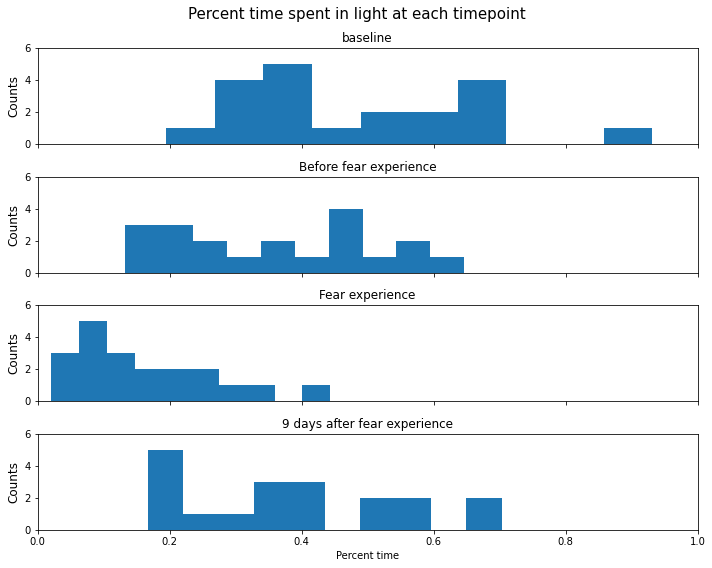

In [98]:
full_name = {"BL": "baseline", "PreF": "Before fear experience", "Fear":"Fear experience", "D9": "9 days after fear experience"}

fig, ax = plt.subplots(nrows=4, ncols=1, squeeze=False, figsize=(10, 8), sharex=True)
fig.suptitle("Percent time spent in light at each timepoint", fontsize=15)
timepoints = Y.Timepoint.unique()
for n, timepoint in enumerate(timepoints):
    ax[n, 0].hist(Y.loc[Y.Timepoint == timepoint]["PerLight"])
    ax[n, 0].title.set_text(full_name[timepoint])
    ax[n, 0].set_ylim(0, 6)
    ax[n, 0].set_ylabel("Counts", fontsize=12)

ax[3, 0].set_xlim(0, 1)
ax[3, 0].set_xlabel("Percent time")
plt.tight_layout()
plt.show()

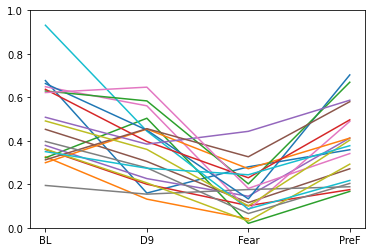

In [99]:
timepoints = np.unique(Y["Timepoint"])

fig, ax = plt.subplots()
for i in range(20): 
    ax.plot(timepoints, Y.loc[(Y.ID==i), "PerLight"], label=str(Y.ID))

ax.set_ylim(0, 1)
fig.show()

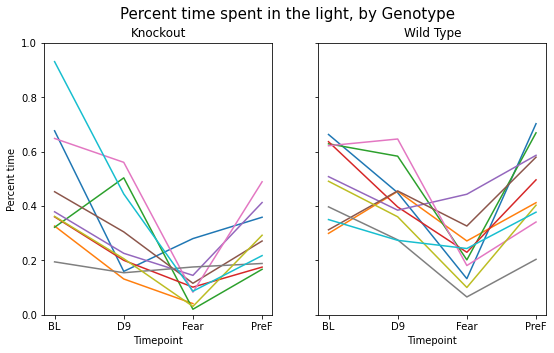

In [122]:
timepoints = np.unique(Y["Timepoint"])

fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
for i in range(20): 
    #plot KO subplot
    selection1 = Y.loc[(Y.ID==i) & (Y.Genotype=="KO"), "PerLight"]
    if not selection1.empty: 
        ax[0].plot(timepoints, selection1, label=str(Y.ID))
#plot WT subplot 
    selection2 = Y.loc[(Y.ID==i) & (Y.Genotype=="WT"), "PerLight"]
    if not selection2.empty: 
        ax[1].plot(timepoints, selection2, label=str(Y.ID))

ax[0].set_ylim(0, 1)
ax[0].set_title("Knockout")
ax[1].set_title("Wild Type")
ax[0].set_ylabel("Percent time")
ax[0].set_xlabel("Timepoint")
ax[1].set_xlabel("Timepoint")
fig.suptitle("Percent time spent in the light, by Genotype", fontsize=15)
fig.show()

In [9]:
#check all images are the same shape 
img_shape = (124, 200, 82)
for fp in os.listdir(mri_dir):
    full_path = os.path.join(mri_dir, fp)
    brain = BU.load_brain(full_path)
    assert brain.shape ==  img_shape
    #print(brain.shape)

In [24]:
np.all(np.equal(brain[5], 0) )

#when there's nothing present in the image, that is represented by a 0 

True

In [17]:
# specify labels for plot (note the labels below are specifically for RAS orientation)
dir_labels = { 'saggital' :   ['P', 'A', 'D', 'V'],
               'coronal' :    ['L', 'R', 'D', 'V'],
               'horizontal' : ['L', 'R', 'A', 'P']} 
# generate interactive plots
mask = np.ones((np.prod(mri_dims), ))
BV.plot_interactive_panels(X[6:9], mri_dims, mask, dir_labels, figsize=(8,3), colormap='Blues')


interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

In [125]:
#checking out the values of the MRI data 
for i, row in enumerate(X): 
    print("smallest", min(row))
    print("biggest", max(row))

smallest -2119.0
biggest 33250.0
smallest -2440.0
biggest 32657.0
smallest -4278.0
biggest 25109.0
smallest -3501.0
biggest 25528.0
smallest -5169.0
biggest 34209.0
smallest -6249.0
biggest 23413.0
smallest -2640.0
biggest 22187.0
smallest -2738.0
biggest 34208.0
smallest -3696.0
biggest 38118.0
smallest -4357.0
biggest 26793.0
smallest -2149.0
biggest 22981.0
smallest -2364.0
biggest 18354.0
smallest -3817.0
biggest 32826.0
smallest -2308.0
biggest 24864.0
smallest -2464.0
biggest 29475.0
smallest -4226.0
biggest 28834.0
smallest -2848.0
biggest 27327.0
smallest -3195.0
biggest 28860.0
smallest -2357.0
biggest 27508.0
smallest -3273.0
biggest 31945.0
smallest -2466.0
biggest 25800.0
smallest -2961.0
biggest 27774.0
smallest -3144.0
biggest 27740.0
smallest -2491.0
biggest 26297.0
smallest -2910.0
biggest 30328.0
smallest -3126.0
biggest 27212.0
smallest -3185.0
biggest 32092.0
smallest -2333.0
biggest 33391.0
smallest -2224.0
biggest 28013.0
smallest -3157.0
biggest 28019.0
smallest -